In [1]:
import pyomo.environ as pyo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import mul
from pyomo.environ import *

In [2]:
from Parameters import * 
db_connection = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="root", # change password
    auth_plugin='mysql_native_password'
)
db_cursor = db_connection.cursor(buffered=True)
db_cursor.execute("USE earthquake")

##### Parameters

In [3]:
def set_victim_parameters(start_time, end_time):
    K = Parameters.num_of_immediate(db_cursor, start_time, end_time) #number of victims with condition 3 (immediate)
    L = Parameters.num_of_delayed(db_cursor, start_time, end_time) #number of victims condition 2 (delay)
    victim_dict = Parameters.victim_dict(db_cursor, start_time, end_time) #all victims
    immediate_v_id_list, delayed_v_id_list = Parameters.victim_id_lists(victim_dict) #immediate and delayed victim id's
    neighbourhood_list, hospital_list, distances = Parameters.distances(victim_dict, hospital_dict)
    y_immediate_list, y_delayed_list = Parameters.y_lists(victim_dict) #age
    t_immediate_list, t_delayed_list = Parameters.t_lists(victim_dict) #time elapsed
    neighbourhood_immediate_list, neighbourhood_delayed_list = Parameters.neighbourhood_lists(victim_dict)
    return K, L, victim_dict, immediate_v_id_list, delayed_v_id_list, neighbourhood_list, hospital_list,\
            distances, y_immediate_list, y_delayed_list, t_immediate_list, t_delayed_list, \
            neighbourhood_immediate_list, neighbourhood_delayed_list

##### Variables

In [4]:
def set_variables(immediate_v_id_list, delayed_v_id_list):
    #x: Binary variable. victim i to hospital j
    m.I = pyo.RangeSet(0, len(immediate_v_id_list)-1)
    m.D = pyo.RangeSet(0, len(delayed_v_id_list)-1)
    m.J = pyo.RangeSet(0, len(hospital_id_list)-1)

    m.K = np.ndarray(shape=(len(immediate_v_id_list),len(hospital_id_list)))
    m.L = np.ndarray(shape=(len(delayed_v_id_list),len(hospital_id_list)))

    def IJ_rule(m):
        return [(i,j) for i in range(len(m.I)) for j in range(len(m.K[i]))]

    def DJ_rule(m):
        return [(d,j) for d in range(len(m.D)) for j in range(len(m.L[d]))]

    m.immediate = Set(within=m.I*m.J, initialize=IJ_rule)
    m.immediate_v = Var(m.immediate, within = Binary) #for immediate
    m.delayed = Set(within=m.D*m.J, initialize=DJ_rule)
    m.delayed_v = Var(m.delayed, within = Binary) #for delayed

##### Objective Function 


In [5]:
def obj_rule(m):
    immediate = 0
    for k in range(K):
        for j in range(H):
            neighbourhood_index = neighbourhood_list.index(neighbourhood_immediate_list[k])
            immediate += c_1*t_immediate_list[k]*y_immediate_list[k]*distances[neighbourhood_index][j]*m.immediate_v[k,j]
            
    delayed = 0
    for l in range(L):
        for j in range(H):
            neighbourhood_index = neighbourhood_list.index(neighbourhood_delayed_list[l])
            delayed += c_2*t_delayed_list[l]*y_delayed_list[l]*distances[neighbourhood_index][j]*m.delayed_v[l,j]
            
    penalty_immediate = K - sum(m.immediate_v[k,j] for k in range(K) for j in range(H))
    
    penalty_delayed = L - sum(m.delayed_v[l,j] for l in range(L) for j in range(H))
    
    return immediate + delayed + epsilon*(c_1*penalty_immediate + c_2*penalty_delayed)

##### Constraints

In [6]:
def bed_capacity_constraint(m, j):
    return sum(m.immediate_v[k, j] for k in range(K)) + sum(m.delayed_v[l, j] for l in range(L)) <= leftover_bed_capacity_list[j]

In [7]:
def allocation_constraint_immediate(m, k):
    return sum(m.immediate_v[k, j] for j in range(H) ) <= 1 

def allocation_constraint_delayed(m, l):
    return sum(m.delayed_v[l, j] for j in range(H) ) <= 1

In [8]:
def update_bed_capacity(bed_capacity_list):
    for j in range(H):
        assigned_immediate = sum(pyo.value(m.immediate_v[k,j]) for k in range(K))
        assigned_delayed = sum(pyo.value(m.delayed_v[l,j]) for l in range(L))    
        bed_capacity_list[j] -= assigned_immediate + assigned_delayed

In [9]:
def solve():
    solver = SolverFactory('glpk')
    solution = solver.solve(m)
    unassigned_immediate = K - sum(pyo.value(m.immediate_v[k,j]) for k in range(K) for j in range(H))
    assigned_immediate = sum(pyo.value(m.immediate_v[k,j]) for k in range(K) for j in range(H))
    unassigned_delayed = L - sum(pyo.value(m.delayed_v[l,j]) for l in range(L) for j in range(H))
    assigned_delayed = sum(pyo.value(m.delayed_v[l,j]) for l in range(L) for j in range(H))
    objective_value = pyo.value(m.objective)
    update_bed_capacity(leftover_bed_capacity_list)
    immediate_hospital_assigned = [0] * H
    delayed_hospital_assigned = [0] * H
    print("------------------------------------------------------------")
    for j in range(H):
        for k in range(K):
            if pyo.value(m.immediate_v[k,j]):
                immediate_hospital_assigned[j] +=1
        for l in range(L):
            if pyo.value(m.delayed_v[l,j]):
                delayed_hospital_assigned[j] += 1
    for j in range(H):
        print(hospital_name_list[j],"reciveved:\n\t",immediate_hospital_assigned[j],"immediate survivors and",delayed_hospital_assigned[j],"delayed survivors.")
                
    return unassigned_immediate, assigned_immediate, unassigned_delayed, assigned_delayed, \
            objective_value
    

In [10]:
def solve_model_periodically(start_time, end_time, bed_capacity_list):    
    global K, L, victim_dict, immediate_v_id_list, delayed_v_id_list, neighbourhood_list, hospital_list, distances,\
    y_immediate_list, y_delayed_list, t_immediate_list, t_delayed_list, neighbourhood_immediate_list,\
    neighbourhood_delayed_list
    K, L, victim_dict, immediate_v_id_list, delayed_v_id_list, neighbourhood_list, hospital_list, distances,\
    y_immediate_list, y_delayed_list, t_immediate_list, t_delayed_list, neighbourhood_immediate_list,\
    neighbourhood_delayed_list = set_victim_parameters(start_time, end_time)
    set_variables(immediate_v_id_list, delayed_v_id_list)
    #more parameters
    global epsilon, c_1, c_2
    c_1 = 1.02 #condition: immediate
    c_2 = 1 #condition: delayed
    #epsilon value is calculated as the average of the coefficients of the x_ij's in order to make the penalty meaningful
    epsilon = (c_2*sum(map(mul, y_immediate_list, t_immediate_list)) + c_1*sum(map(mul, y_delayed_list, t_delayed_list)))/(c_1+c_2)
    m.objective = pyo.Objective(rule=obj_rule, sense=pyo.minimize)
    m.bed_capacity_constraint = pyo.Constraint(range(H), rule = bed_capacity_constraint)
    m.allocation_constraint_immediate = pyo.Constraint(range(K), rule = allocation_constraint_immediate)
    m.allocation_constraint_delayed = pyo.Constraint(range(L), rule = allocation_constraint_delayed)
    return solve()

In [11]:
#only queried once
H = Parameters.num_of_hospitals(db_cursor) #operational hospitals
hospital_dict = Parameters.hospital_dict(db_cursor) 
hospital_id_list = Parameters.hospital_id_lists(hospital_dict)
hospital_name_list = Parameters.hospital_name_lists(hospital_dict)
leftover_bed_capacity_list = Parameters.hospital_bed_capacity_lists(hospital_dict)
records = {}
K_list = []
assigned_immediate_list=[]
L_list = []
assigned_delayed_list=[]
bed_capacity_list = []
def record_of_allocation(time_interval):
    global leftover_bed_capacity_list
    global m
    i = 0
    while sum(leftover_bed_capacity_list):
        start_time = i*time_interval
        end_time = (i+1)*time_interval
        m = pyo.ConcreteModel()
        unassigned_immediate, assigned_immediate, unassigned_delayed, assigned_delayed, \
        objective_value = solve_model_periodically(start_time, end_time, leftover_bed_capacity_list)
        # get K and L from solve_model_periodically
        K_list.append(K)
        assigned_immediate_list.append(assigned_immediate)
        L_list.append(L)
        assigned_delayed_list.append(assigned_delayed)
        bed_capacity_list.append(sum(leftover_bed_capacity_list))
        records[i] = {"Unassigned immediate": unassigned_immediate, "Assigned immediate": assigned_immediate, \
                    "Unassigned delayed": unassigned_delayed, "Assigned delayed": assigned_delayed, \
                    "Objective value": objective_value}
        i += 1
    return records

In [12]:
time_interval = 20
result = record_of_allocation(time_interval)
print("---------------------------------------------------------------------------") 
print("Number of immediate victims in each iteration: ", K_list)
print("Number of delayed victims in each iteration", L_list)
print("Available total bed capacity in each iteration: ", bed_capacity_list)

------------------------------------------------------------
Özel Avicenne Hospital reciveved:
	 21 immediate survivors and 77 delayed survivors.
Özel Doğa Hastanesi reciveved:
	 0 immediate survivors and 0 delayed survivors.
Özel Eslife Esenyurt Hastanesi reciveved:
	 0 immediate survivors and 0 delayed survivors.
Özel Esenler Ensar Hastanesi reciveved:
	 7 immediate survivors and 33 delayed survivors.
Özel Güney Hastanesi reciveved:
	 1 immediate survivors and 5 delayed survivors.
İstanbul Medipol Üniversitesi Esenler Hastanesi reciveved:
	 1 immediate survivors and 7 delayed survivors.
Medilife Bağcılar Hastanesi reciveved:
	 2 immediate survivors and 4 delayed survivors.
Basaksehir Devlet Hastanesi reciveved:
	 0 immediate survivors and 0 delayed survivors.
------------------------------------------------------------
Özel Avicenne Hospital reciveved:
	 0 immediate survivors and 5 delayed survivors.
Özel Doğa Hastanesi reciveved:
	 0 immediate survivors and 0 delayed survivors.
Özel

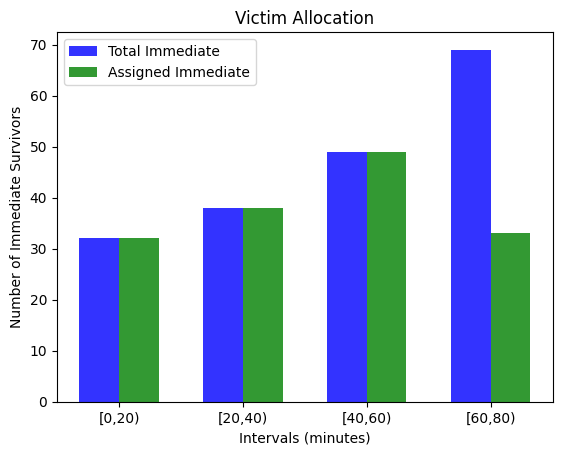

<Figure size 400x400 with 0 Axes>

In [13]:
# data to plot
n_groups = 4

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)/4
bar_width = 0.08
opacity = 0.8

rects1 = plt.bar(index + bar_width/2, K_list, bar_width,
alpha=opacity,
color='b',
label='Total Immediate', align='center')

rects2 = plt.bar(index + 3*bar_width/2, assigned_immediate_list, bar_width,
alpha=opacity,
color='g',
label='Assigned Immediate', align='center')

plt.xlabel('Intervals (minutes)')
plt.ylabel('Number of Immediate Survivors')
plt.title('Victim Allocation')
plt.xticks(index + bar_width, ('[0,20)', '[20,40)', '[40,60)', '[60,80)'))
plt.legend()
plt.figure(figsize=(4,4))
plt.tight_layout()
plt.show()

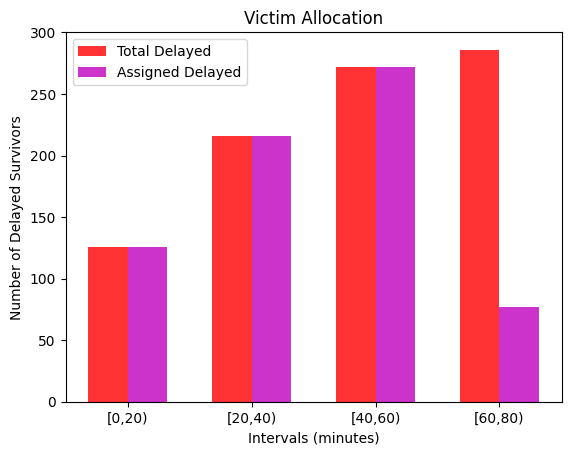

<Figure size 400x400 with 0 Axes>

In [14]:
rects3 = plt.bar(index + bar_width/2, L_list, bar_width,
alpha=opacity,
color='r',
label='Total Delayed', align='center')

rects4 = plt.bar(index + 3*bar_width/2, assigned_delayed_list, bar_width,
alpha=opacity,
color='m',
label='Assigned Delayed', align='center')

plt.xlabel('Intervals (minutes)')
plt.ylabel('Number of Delayed Survivors')
plt.title('Victim Allocation')
plt.xticks(index + bar_width, ('[0,20)', '[20,40)', '[40,60)', '[60,80)'))
plt.legend()
plt.figure(figsize=(4,4))
plt.tight_layout()
plt.show()

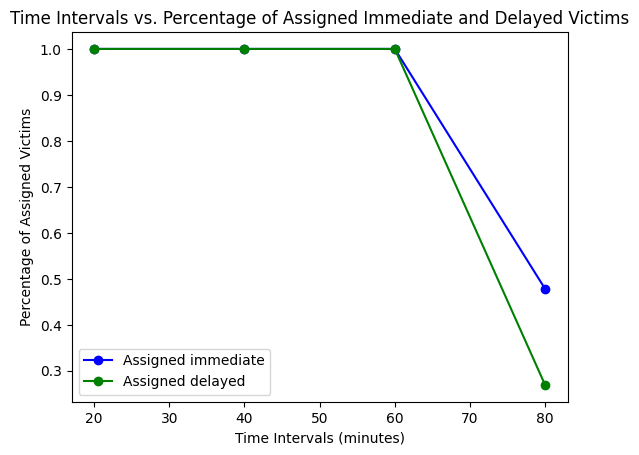

In [15]:
# Graph of percentage of assigned immediate and delayed victims over time
x = list(result.keys())
x_time = [(i+1)*time_interval for i in x]
y_immediate = [result[key]['Assigned immediate']/K_list[key] for key in x]
y_delayed = [result[key]['Assigned delayed']/L_list[key] for key in x]
plt.plot(x_time, y_immediate, 'o-', label = "Assigned immediate", color='b')
plt.plot(x_time, y_delayed, 'o-', label = "Assigned delayed", color='g')
plt.xlabel('Time Intervals (minutes)')
plt.ylabel('Percentage of Assigned Victims')
plt.title('Time Intervals vs. Percentage of Assigned Immediate and Delayed Victims')
plt.legend()
plt.show()

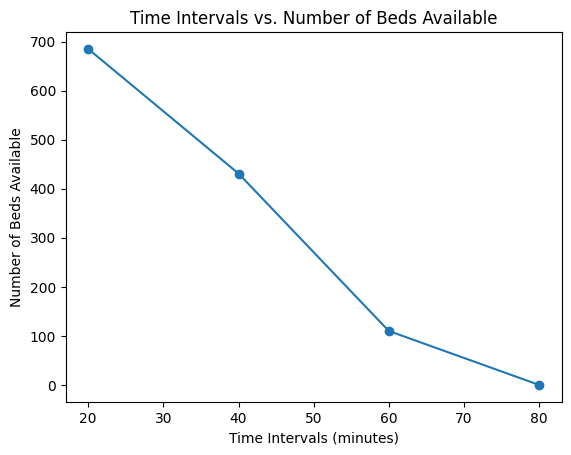

In [16]:
# Graph of the number of beds available over time
x = list(result.keys())
x_time = [(i+1)*time_interval for i in x]
y = bed_capacity_list
plt.plot(x_time, y, 'o-')
plt.xlabel('Time Intervals (minutes)')
plt.ylabel('Number of Beds Available')
plt.title('Time Intervals vs. Number of Beds Available')
plt.show()


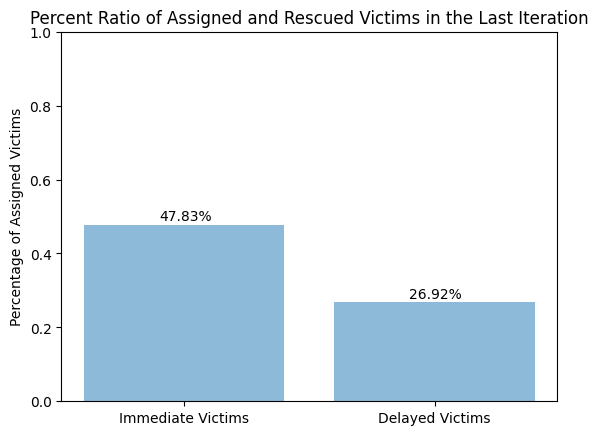

In [17]:
# Bar chart of the percentage of assigned immediate and delayed victims in the last iteration
labels = 'Immediate Victims', 'Delayed Victims'
sizes = [result[len(result)-1]['Assigned immediate']/K_list[len(result)-1], result[len(result)-1]['Assigned delayed']/L_list[len(result)-1]]
y_pos = np.arange(len(labels))
plt.bar(y_pos, sizes, align='center', alpha=0.5)
for i in range(len(sizes)):
    plt.text(x = y_pos[i]-0.1, y = sizes[i]+0.01, s = str(round(sizes[i]*100,2))+"%")
axes = plt.gca()
axes.set_ylim([0,1])
plt.xticks(y_pos, labels)
plt.ylabel('Percentage of Assigned Victims')
plt.title('Percent Ratio of Assigned and Rescued Victims in the Last Iteration', wrap=True)
plt.show()